# AC_offset_test 

We test the accuracy of the SDSS-CRTS offsets using CRTS standard stars. For SDSS we assume constant magnitude (since the actual light curves are not really available) . 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [11]:
# Read the table with SDSS-CRTS stars ... 
address = '../../CRTS_PROJECT/data_products/CRTS_SDSS_combined_stars_catalog.dat'
s82_stars = Table.read(address, format='ascii')

# add StarID : a unique identifier tying it to the stripe82calibstars catalog ...
# otherwise each star is only known by the CRTS name which is not ideal ...
s82  = Table.read('stripe82calibStars_v2.6_starID.txt' , format='ascii')
s82_coords = SkyCoord(ra=s82['RA'].data*u.degree, 
                     dec= s82['Dec'].data*u.degree)
sdss_coords = SkyCoord(ra=s82_stars['ra_sdss'].data*u.degree, 
                           dec=s82_stars['dec_sdss'].data*u.degree)
# match SDSS Stars to S82 , because SDSS Stars has 48250 rows, and S82 catalog 1 mln + 
idx, sep2d, dist3d = sdss_coords.match_to_catalog_sky(s82_coords) 
s82_stars['d2d_s82']=sep2d.value*3600
s82_stars = hstack([s82_stars, s82[['starID']][idx] ])
print('Done')

# store the updated CRTS-SDSS standard stars catalog ...
s82_stars.write("CRTS_SDSS_combined_stars_catalog_upd.txt", format='ascii')



Done


In [114]:
# read in the offsets , as derived in AC_SDSS_PTF_CRTS_offsets.ipynb 
offset  = Table.read('Offsets_CRTSV-SDSSr_SDSSgi_ext-NO.txt', format='ascii')
b0 = offset['B_0'][0]
b1 = offset['B_1'][0]

In [115]:
offset

x,y,B_0,B_1
str10,str14,float64,float64
(g-i)_SDSS,V_CRTS-r_SDSS),-0.0464128195723,-0.0127575771499


In [116]:
b1

-0.01275757714986161

In [16]:
# sort by CRTS number of epochs ( days in the processed LC ... )
s82_stars.sort('proc_lc_length')

In [77]:
# it sorts in descending order ... choose the last one 
i = -1 


In [83]:
for i in range(-10,-1):
    print(i)

-10
-9
-8
-7
-6
-5
-4
-3
-2


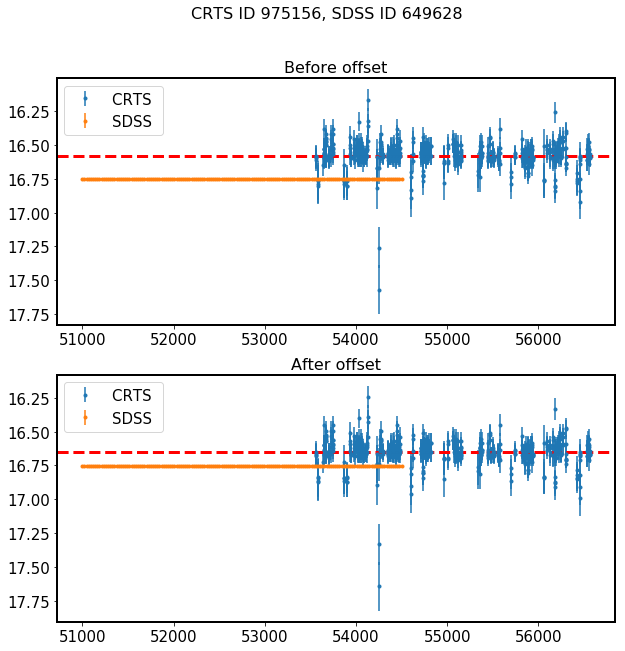

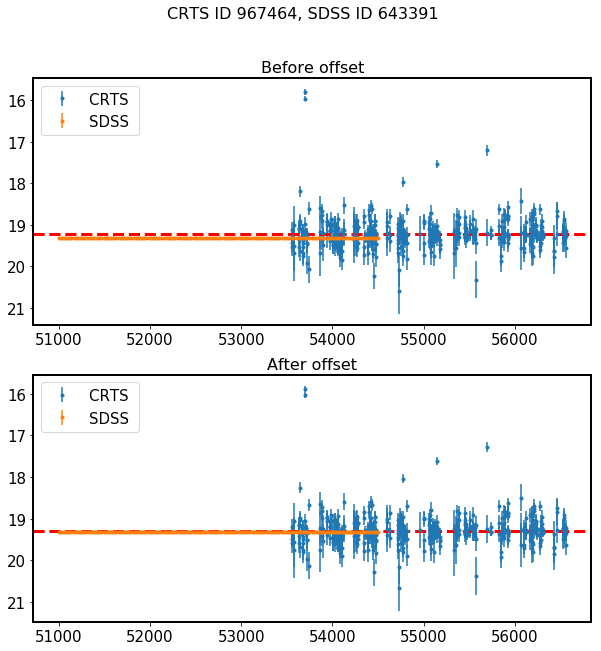

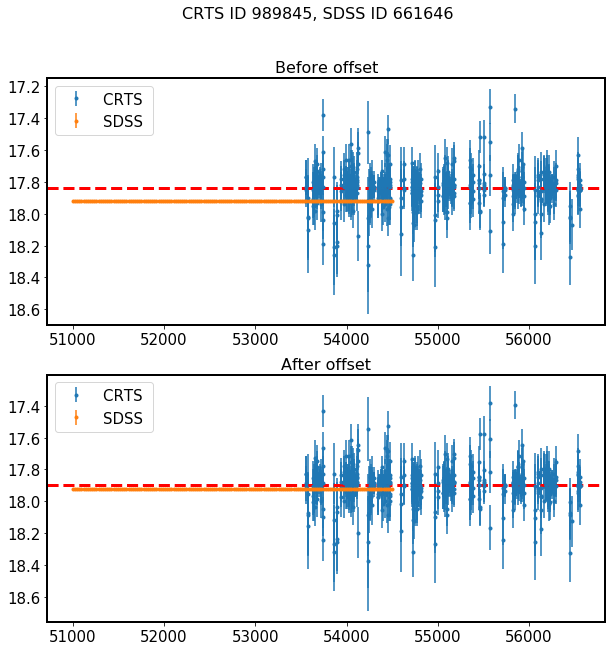

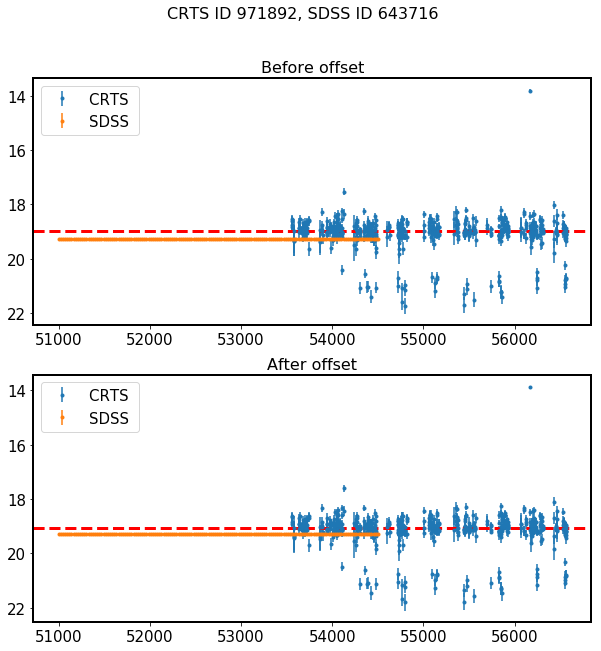

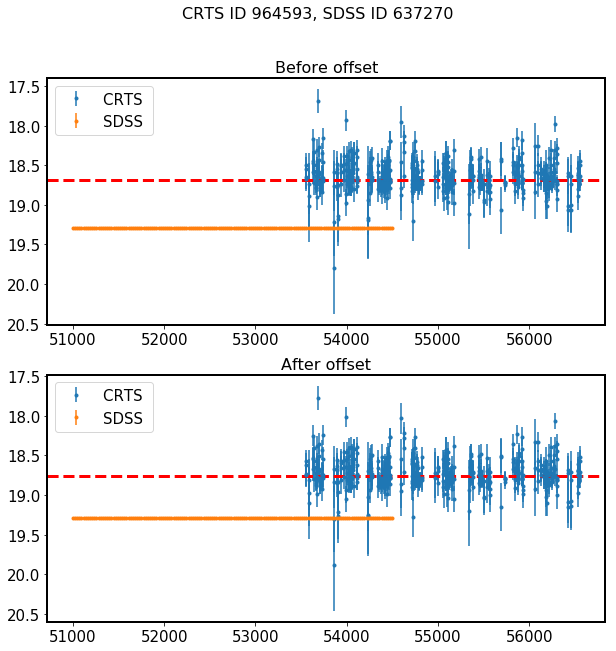

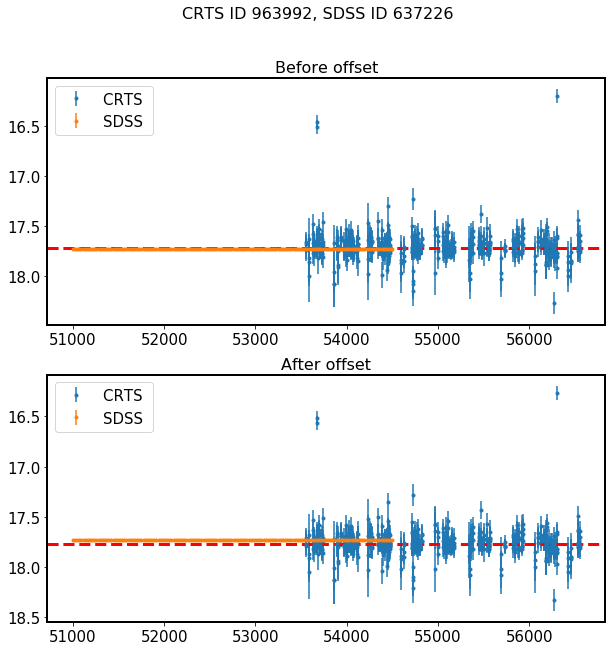

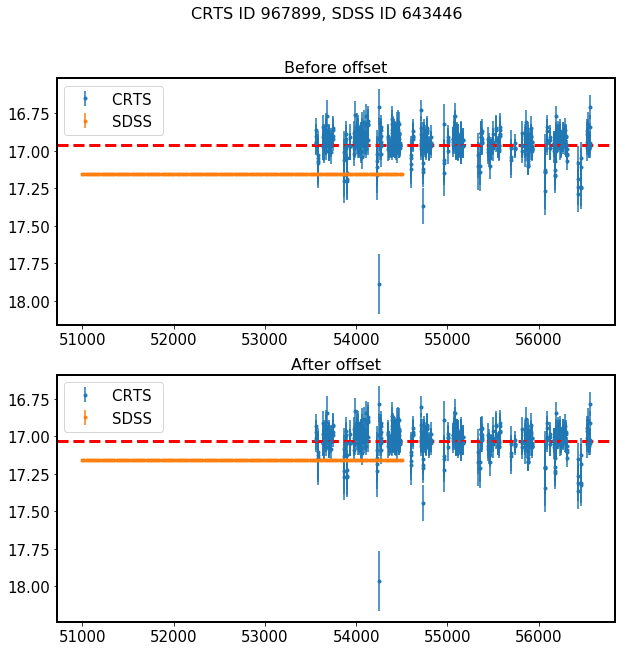

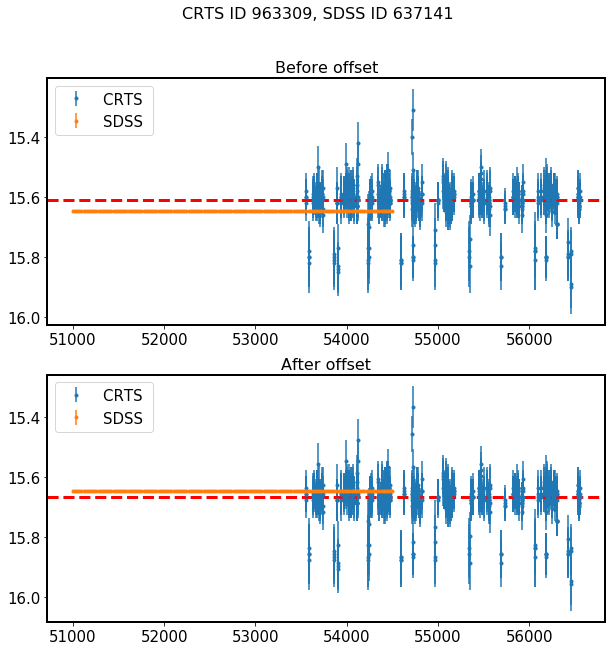

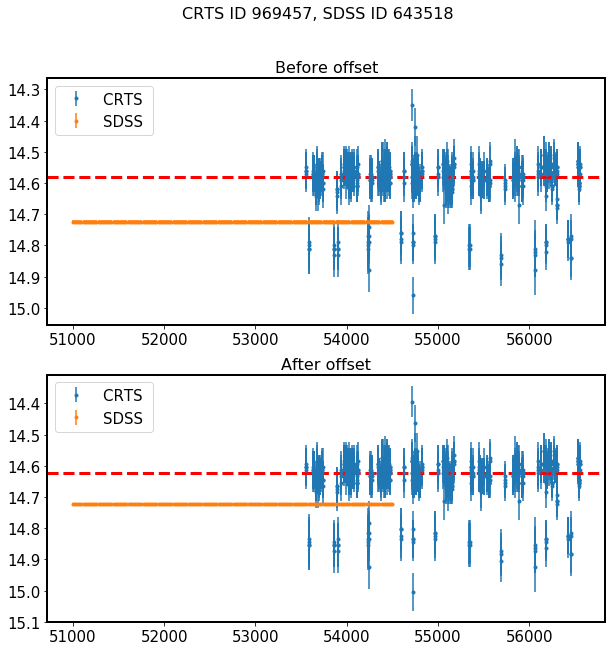

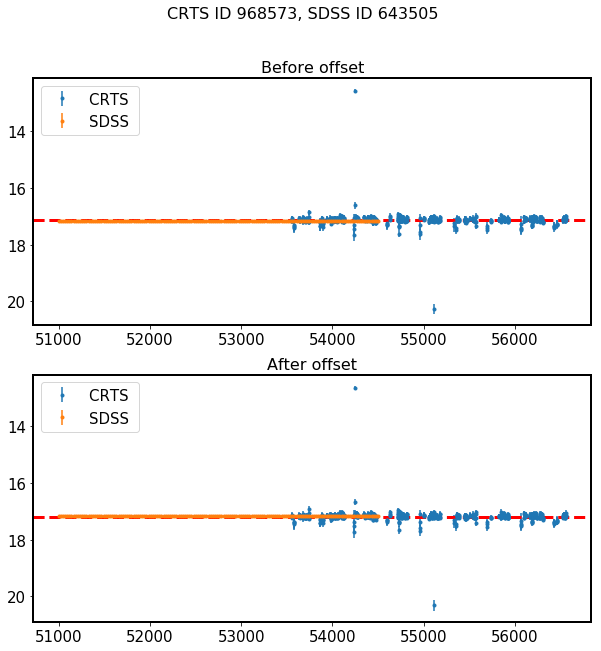

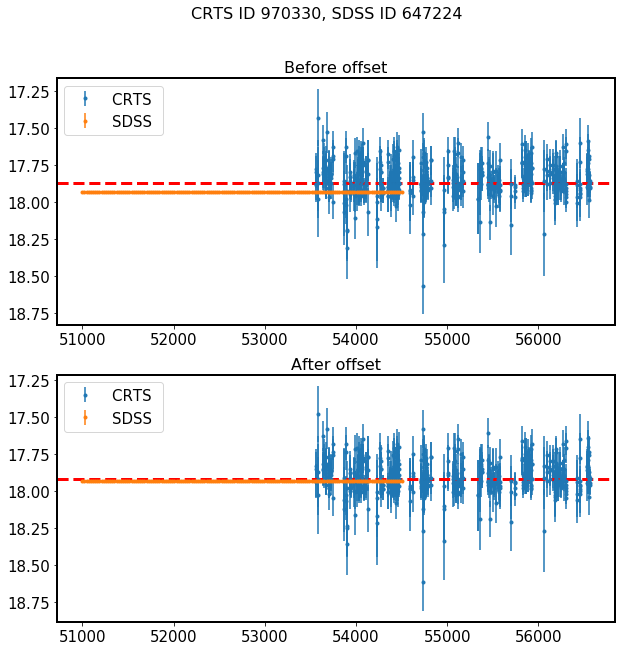

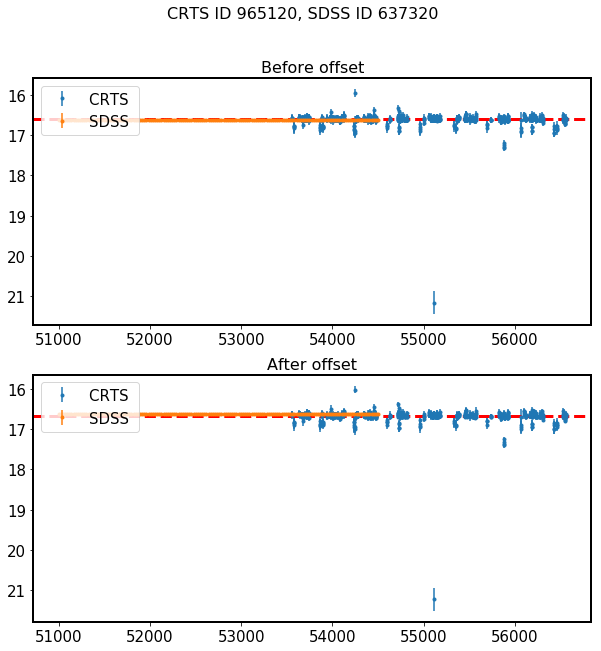

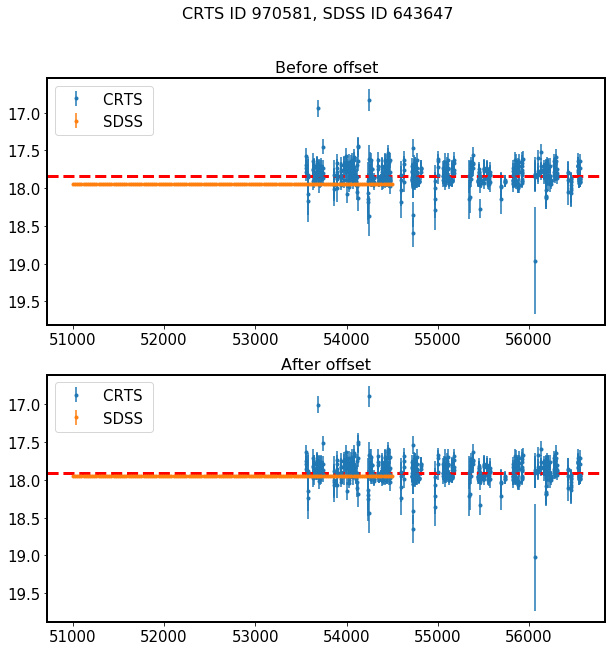

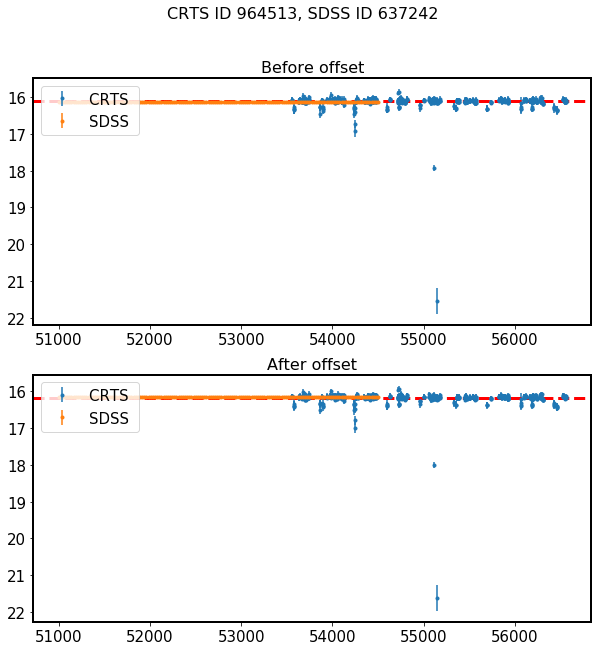

In [118]:
%matplotlib inline
for i in range(-15,-1):
    lcname = str(s82_stars['CRTS_name'][i]) + '.dat'
    sdssname =str(s82_stars['starID'][i])

    # Given a star : 
    # find the SDSS(g-i) color 
    gi = s82_stars['g_mMed'][i] - s82_stars['i_mMed'][i]

    # read in the CRTS light curve 
    crtsDir  = '/Users/chris/GradResearch/CRTS_PROJECT/raw_LC_CRTS/stars/'
    lc = Table.read(crtsDir  + lcname, format='ascii',
                   names=['mjd', 'mag', 'magerr', '0'])
    
    # apply the offset 
    lc['magoff'] = lc['mag'] - b0 - b1*gi

    # make a fake SDSS light curve, 
    # assuming a constant magnitude equal to the 
    # median r magnitude, 
    # over 150 epochs between the beginning and 
    # and of SDSS observations...
    
    sdss_mjds = np.linspace(51000, 54500, 150)
    sdss_mags = s82_stars['r_mMed'][i]  * np.ones_like(sdss_mjds)
    sdss_errs = s82_stars['r_mErr'][i]  * np.ones_like(sdss_mjds)
    
    
    fig,axs = plt.subplots(2,1,figsize = (10,10))
    ax = np.ravel(axs)

    # plot the original CRTS light curve , 
     # and the light curve after applying the offset 
    # plot sdss, crts, and median of CRTS obs .... 
    for j, col, title in zip([0,1], ['', 'off'], ['Before', 'After']):
        ax[j].errorbar(lc['mjd'], lc['mag'+col], lc['magerr'], 
                label='CRTS ', fmt=".", capsize=0)

        ax[j].axhline(np.median(lc['mag'+col]), ls='--', lw='3' ,c='red')

        ax[j].errorbar(sdss_mjds, sdss_mags, sdss_errs, 
                    label='SDSS', fmt=".", capsize=0)
        ax[j].legend(fontsize=15, loc='upper left')

        ax[j].set_title(title+' offset', fontsize=16)
        ax[j].invert_yaxis()
    fig.suptitle('CRTS ID '+ lcname[:-4]+ ', SDSS ID '+sdssname, fontsize=16)
    plt.savefig('../data_products/Offsets_tests/LC_'+lcname[:-4]+'_test_SDSS_CRTS.png',
               bbox_inches='tight')

Inconclusive : I find that the offset is not right!  Perhaps I should redo the CRTS offsets.... I have no idea why they do not work as expected. 

Plot the distribution of median CRTS-SDSS difference : before and after the offset "correction" 

In [87]:
s82_stars[-10]

raw_mjd_span,raw_mean_mag,raw_mean_err,CRTS_name,raw_lc_length,proc_mean_N_day,proc_mean_err,proc_lc_length,proc_mean_mag,proc_mjd_span,ra_crts,dec_crts,calib_fla,ra_sdss,dec_sdss,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,d2d_s82,starID,medCRTSbefore,medCRTSafter
float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64
2997.84197,17.706541502,0.10209486166,963992,506.0,3.89230769231,0.0537869230769,130.0,17.7055084615,2997.8188,352.6275635,-1.247695,CALIBSTARS,352.6275635,-1.247695,0.021,0.015,10,0.115,10,19.505,19.504,0.01,0.034,0.9,10,18.248,18.24,0.007,0.023,0.9,10,17.735,17.732,0.005,0.015,1.2,10,17.531,17.535,0.005,0.014,0.8,10,17.451,17.457,0.007,0.017,0.6,0.0,637226,1.0,1.0


In [86]:
# Initiate new columns
s82_stars['medCRTSbefore'] = np.ones_like(s82_stars['raw_mjd_span'])
s82_stars['medCRTSafter'] = np.ones_like(s82_stars['raw_mjd_span'])

In [112]:
# Calculate the median for CRTS light curve 
# before and after offset 
for i in range(len(s82_stars)):# range(-501,-1):
    lcname = str(s82_stars['CRTS_name'][i]) + '.dat'
    sdssname =str(s82_stars['starID'][i])

    # Given a star : 
    # find the SDSS(g-i) color 
    gi = s82_stars['g_mMed'][i] - s82_stars['i_mMed'][i]

    # read in the CRTS light curve 
    crtsDir  = '/Users/chris/GradResearch/CRTS_PROJECT/raw_LC_CRTS/stars/'
    lc = Table.read(crtsDir  + lcname, format='ascii',
                   names=['mjd', 'mag', 'magerr', '0'])
    
    s82_stars['medCRTSbefore'][i] = np.median(lc['mag'])
    
    # apply the offset 
    lc['magoff'] = lc['mag'] - b0 - b1*gi
    s82_stars['medCRTSafter'][i] = np.median(lc['magoff'])
    

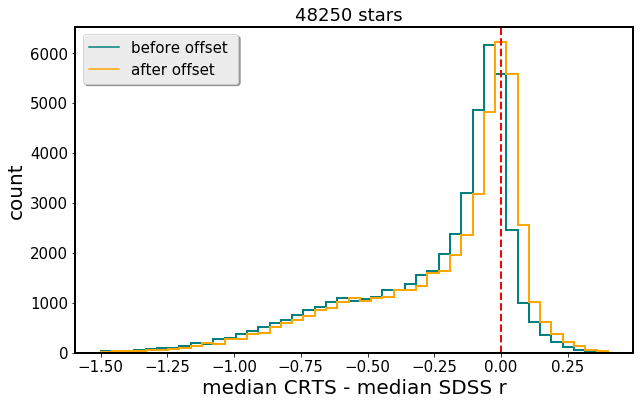

In [126]:
%matplotlib inline
import matplotlib.lines as mlines
m = s82_stars['medCRTSbefore'] > 1  # only remove obviously bad with negative fluxes 
fig,ax = plt.subplots(1,1,figsize= (10,6))
ax_legend_handles = []
colors = ['teal', 'orange']
i = 0 
for when in ['before', 'after']:
    ax.hist(s82_stars['medCRTS'+when][m] - s82_stars['r_mMed'][m], bins=45,
           histtype='step', lw=2,color=colors[i],
           range=(-1.5,0.4))
    line = mlines.Line2D([], [],  color=colors[i], label=when+' offset ')
    ax_legend_handles.append(line)
    i += 1 

ax.legend(loc='upper left', handles = ax_legend_handles,
            # bbox_to_anchor=(1.0, 1.0),
             ncol=1, fancybox=True, shadow=True , fontsize=15) 
ax.set_xlabel('median CRTS - median SDSS r')
ax.set_ylabel('count')
ax.axvline(0.0, ls='--', lw=2,c='red')
ax.set_title( str(np.sum(m)) \
             + ' stars  ' )
plt.savefig('../data_products/Offsets_tests/CRTS_SDSS_offset_stars.png', 
            bbox_inches='tight')